In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import numpy as np
import cv2
import glob
import pickle

In [2]:
import math

In [3]:
img = plt.imread("C:/Users/Administrator/Desktop/双目/Lena.jpg")

In [72]:
sigma1 = sigma2 = 1
summ = 0

gaussian = np.zeros([5, 5])
for i in range(5):
    for j in range(5):
        gaussian[i, j] = math.exp(-1/2 * (np.square(i-2) / np.square(sigma1) + 
                                         np.square(j-2))) / (2 * math.pi * sigma1 *sigma2)
        summ += gaussian[i, j]
        
gaussian /= summ
print(gaussian)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


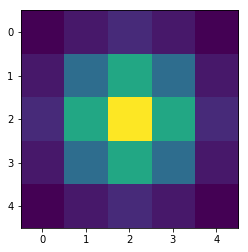

In [73]:
plt.imshow(gaussian)
plt.show()

In [75]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

In [76]:
#1 高斯滤波
gray = rgb2gray(img)
W, H = gray.shape

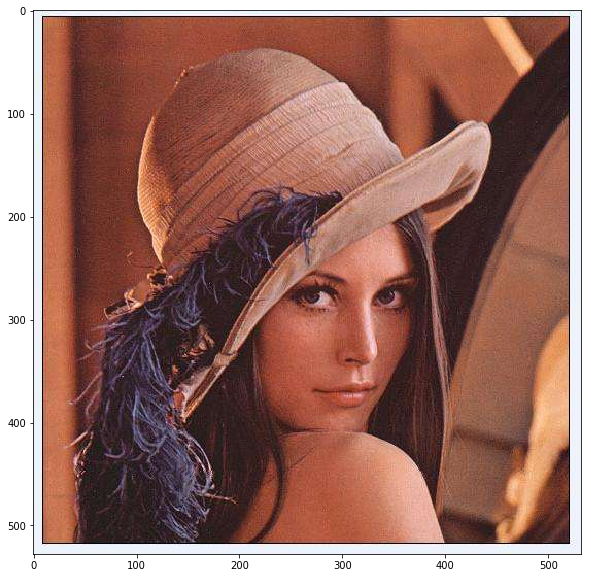

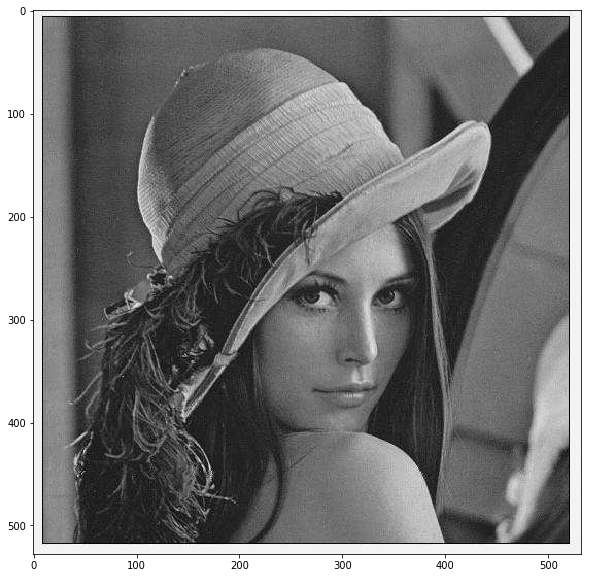

In [89]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()
fig = plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap='gray')
plt.show()

In [80]:
new_gray = np.zeros([W - 5, H - 5])
for i in range(W - 5):
    for j in range(H - 5):
        new_gray[i, j] = np.sum(gray[i:i +5, j:j +5] * gaussian)
        # 卷积，做滤波处理

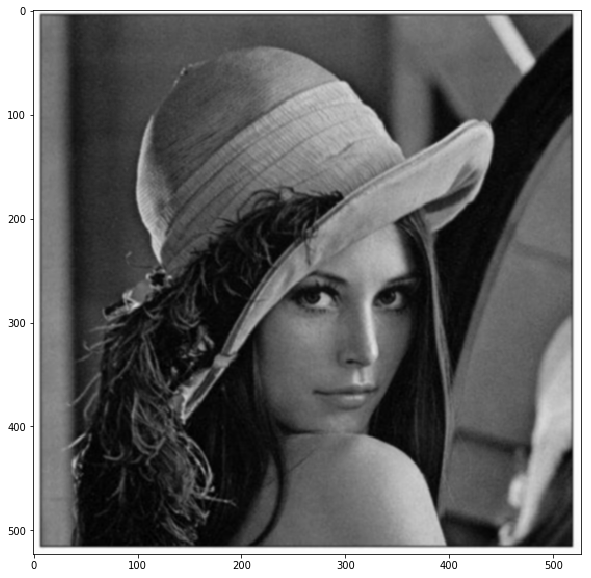

In [87]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(new_gray, cmap='gray')
plt.show()

In [126]:
#2 求梯度幅值
# 简单求导
W1, H1 = new_gray.shape
dx = np.zeros([W1 - 1, H1 - 1])
dy = np.zeros([W1 - 1, H1 - 1])
d = np.zeros([W1 - 1, H1 - 1])
for i in range(W1 - 1):
    for j in range(H1 - 1):
        dx[i, j] = new_gray[i, j+1] - new_gray[i, j]
        dy[i, j] = new_gray[i+1, j] - new_gray[i, j]
        d[i, j] = np.sqrt(np.square(dx[i, j]) + np.square(dy[i, j]))

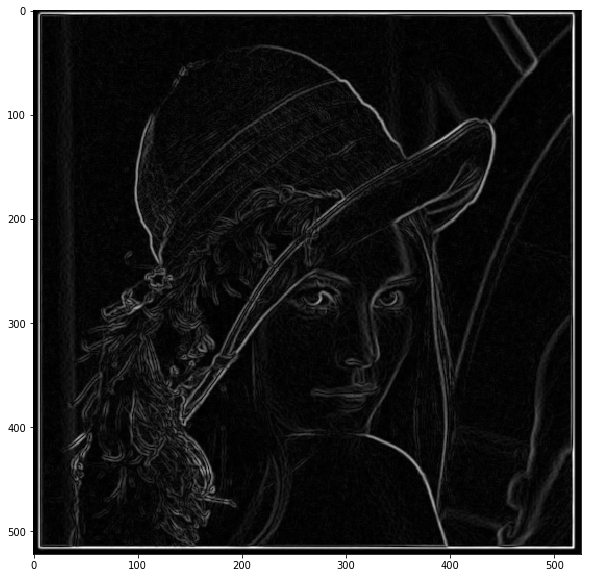

In [86]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(d, cmap='gray')
plt.show()

In [97]:
# 使用Sobel算子计算梯度
Gx = 1/8 * np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Gy = 1/8 * np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
new_dx = np.zeros([W1 - 2, H1 - 2])
new_dy = np.zeros([W1 - 2, H1 - 2])
new_d = np.zeros([W1 - 2, H1 - 2])
theta = np.zeros([W1 - 2, H1 - 2])
for i in range(1, W1 - 3):
    for j in range(1, H1 - 3):
        new_dx[i, j] = np.sum(new_gray[i-1:i+2, j-1:j+2] * Gx)
        new_dy[i, j] = np.sum(new_gray[i-1:i+2, j-1:j+2] * Gy)
        new_d[i, j] = np.sqrt(np.square(new_dx[i, j]) + np.square(new_dy[i, j]))
        theta[i, j] = math.atan(new_dx[i,j] / (new_dy[i, j] + 0.0000000010))

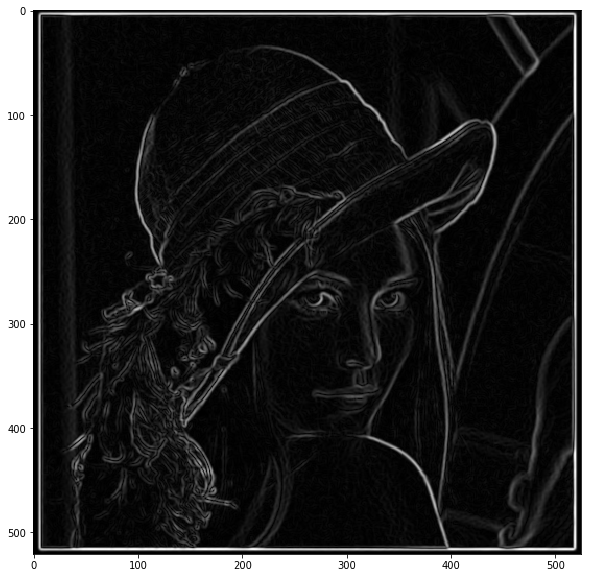

In [96]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(new_d, cmap='gray')
plt.show()

In [99]:
dx = new_dx
dy = new_dy
d = new_d

In [101]:
#3 非极大值抑制 NMS
W2, H2 = d.shape
NMS = np.copy(d)
NMS[0, :] = NMS[H2 - 1:] = NMS[:, 0] = NMS[:, W2 - 1] = 0
for i in range(1, W2 - 1):
    for j in range(1, H2 - 1):
        
        if d[i, j] == 0:
            NMS[i, j] = 0
        else:
            gradX = dx[i, j]
            gradY = dy[i, j]
            gradTemp = d[i, j]
            
            # 如果y方向幅值较大
            if np.abs(gradY) > np.abs(gradX):
                weight = np.abs(gradX) / np.abs(gradY)
                grad2 = d[i - 1, j]
                grad4 = d[i + 1, j]
                # 如果x，y方向梯度符号相同：
                if gradX * gradY > 0:
                    grad1 = d[i - 1, j - 1]
                    grad3 = d[i + 1, j + 1]
                else:
                    grad1 = d[i - 1, j + 1]
                    grad3 = d[i + 1, j - 1]
                    
            # 如果x方向幅值较大
            else:
                weight = np.abs(gradY) / np.abs(gradX)
                grad2 = d[i, j - 1]
                grad4 = d[i, j + 1]
                if gradX * gradY > 0:
                    grad1 = d[i - 1, j - 1]
                    grad3 = d[i + 1, j + 1]
                else:
                    grad1 = d[i + 1, j - 1]
                    grad3 = d[i - 1, j + 1]
                    
            gradTemp1 = weight * grad1 + (1 - weight) * grad2
            gradTemp2 = weight * grad3 + (1 - weight) * grad4
            if gradTemp >= gradTemp1 and gradTemp >= gradTemp2:
                NMS[i, j] = gradTemp
            else:
                NMS[i, j] = 0

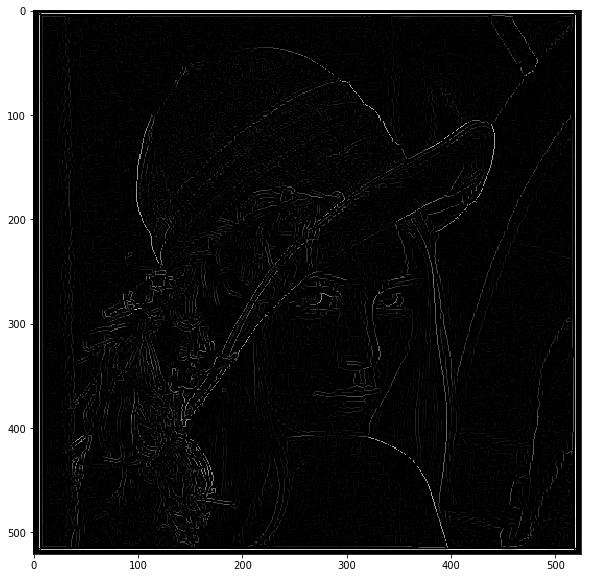

In [102]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(NMS, cmap='gray')
plt.show()

In [124]:
#4 双阈值算法检测、连接边缘
W3, H3 = NMS.shape
result = np.zeros([W3, H3])

thresholdLow = 0.1 * np.max(NMS)
thresholdHigh = 0.2 * np.max(NMS)
for i in range(1, W3 - 1):
    for j in range(1, H3 - 1):
        if NMS[i, j] < thresholdLow:
            result[i, j] = 0
        elif NMS[i, j] > thresholdHigh:
            result[i, j] = 1
        elif (NMS[i-1, j-1:j+1] < thresholdHigh).any() or (NMS[i, [j-1, j+1]] < thresholdHigh).any() or(NMS[i+1, j-1:j+1] < thresholdHigh).any():
            result[i, j] = 1

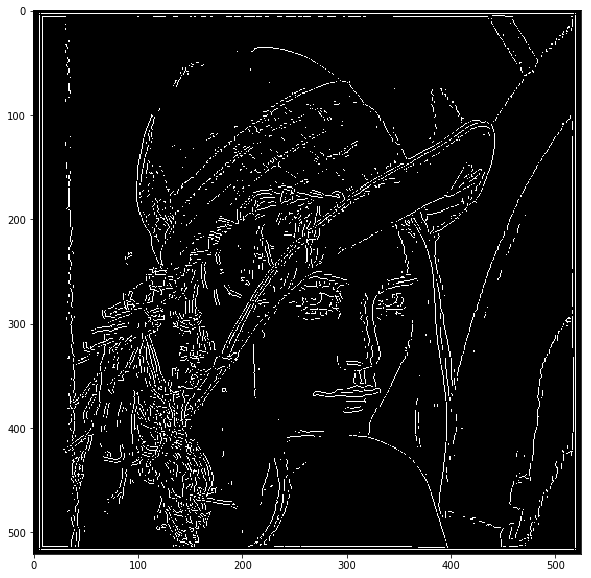

In [125]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(result, cmap='gray')
plt.show()